# STUDY 4: The effect of price movements on market reliability 

### Study assumption
Prices that fluctuate between their
release and the start of a race represent market
uncertainty.

### Data used
 Betfair exchange market data from 2010 -
2022

### Introduction

 This study will explore horses with
fluctuating odds (prices) in the UK horse racing market.
The opening odds for a race are usually released by
bookmakers and exchanges between 5-7pm the day
before the race. These initial prices are calculated using
their own algorithms, but once released, the market can
influence the price of a horse by reflecting the amount of
activity for or against it. This activity can cause the price of
a horse to fluctuate, which we can classify into three
categories: steamers, constants, and drifters.

#### Steamers
Prices that shrink between their
first release and the race start, indicating market
optimism about the horse's chances.
#### Constants
Prices that remain fairly stable
from their initial release to the start of the race,
indicating market confidence in the initial pricing.
#### Drifters
Prices that increase, indicating
market scepticism about the horse's chances.

In this study, we will focus specifically on drifters, horses with
increasing prices. Using data from the Betfair exchange, we
will examine the price movement of these horses. We will also
consider bookmaker prices, specifically the earlier `key time`
metrics we generated in the wrangling process, to compare
the results to those obtained from the exchange data in a
separate study.

### Key Findings

- The biggest drifters tend to have a significantly higher
return on investment compared to other drifters.

- One must consider the impact of a few significant results and variants 
on the overall results of a strategy when examining its
potential to produce long term returns.

### EDA
For this study, we will utilise data from Betfair Exchange, spanning a 12-year period from 2010 to 2022. Specifically, we will examine two columns: 
- `morningwap`, representing the average weighted price traded before 11 am on the morning of the race.
- `ppwap`, representing the total average weighted price traded before the race commences. 

In this study, we will only be looking at price below 250

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings("ignore")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set(rc={'figure.figsize':(2.5,1.5)})
sns.set_style("white")

In [3]:
title_font = {'family': 'Trebuchet MS', 'weight': 'semibold', 'size': 5, 'color': 'dimgrey'}
label_font = {'family': 'Trebuchet MS', 'size': 4, 'color': 'dimgrey'}

In [4]:
bsp_cols = ['name', 'time', 'date', 'morningwap', 'ppwap', 'bsp', 'bspr', 'W/L']
df = pd.read_csv('data/2010-22_BSP Data.csv', usecols=bsp_cols).query('bsp<=250 & morningwap>1' )

In [5]:
df.head()

,name,W/L,bsp,ppwap,morningwap,date,time,bspr
0,The Sneezer,0.0,4.134344,3.966424,3.919814,01/01/2010,12:20,-1.000000
1,Echo Bob,0.0,4.734877,4.465489,4.806486,01/01/2010,12:20,-1.000000
2,Club Oscar,0.0,5.910360,6.725826,10.444861,01/01/2010,12:20,-1.000000
3,Grand Lahou,1.0,7.472524,7.024772,6.711044,01/01/2010,12:20,6.343073
4,Nans Best,0.0,9.246182,8.580233,7.092181,01/01/2010,12:20,-1.000000


Getting the change in price between the `morningwap` and the final starting price (BSP) for each horse. Then splitting these change values into deciles and comparing the distribution of prices within each percentile. The lower the percentile, the more a price has drifted (increased in price). Conversely, the higher the percentile, the more a price has steamed (decreased in price).

In [6]:
df['change_morningwap_bsp'] = df['morningwap']/df['bsp']

In [7]:
df["change_morning_bsp_decile"] = pd.qcut(df.change_morningwap_bsp, q=10, precision=1, labels=range(1, 11))

`boxplot` displaying the relationship between price and our `change_morning_bsp_percentile` values.

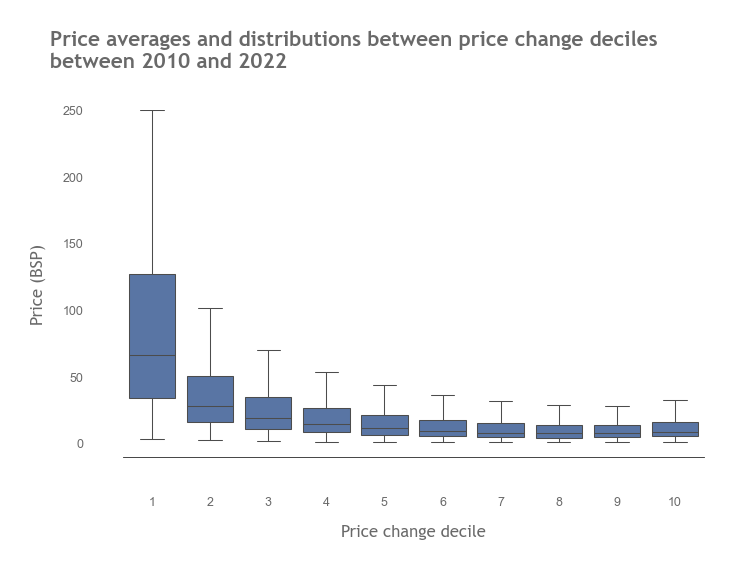

In [8]:
# create the figure and axes
fig, ax = plt.subplots()

# plot boxplot
sns.boxplot(x='change_morning_bsp_decile', y='bsp', data=df, showfliers=False, linewidth=.25, color='b', ax=ax)

# set title and axis labels
ax.set_title('Price averages and distributions between price change deciles\nbetween 2010 and 2022 ',
             fontdict=title_font, x=-0.125, y=1.05, ha='left')
ax.set_ylabel('Price (BSP)', fontdict=label_font)
ax.set_xlabel('Price change decile', fontdict=label_font)

# adjust axis, grid lines
sns.despine(left=True)
ax.spines['bottom'].set_linewidth(.2)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)

# set range
plt.ylim(-10,250)

plt.show()

In [9]:
df['change_morning_bsp_decile'].corr(df['bsp']).round(3)

-0.431

In [10]:
df[df.change_morning_bsp_decile==1].bsp.mean().round(3)

86.186

We see a similar pattern to our previous studies, in which the prices of horses have a significant impact on their change_morningwap_bsp value. Specifically, larger prices tended to be in the percentiles that had the greatest drift, or increase in odds. While this general trend is to be expected with horses with increasing prices, to mitigate the effect of price on change_morningwap_bsp, we can compare the price change with the average for a given price range rather than comparing it to all other prices. 

In [11]:
df = (df
      .assign(bsp_decile = pd.qcut(df["bsp"], q=10, precision=1, labels=range(1, 11)))
      .assign(change_morning_bsp_average = lambda x: x.groupby('bsp_decile', as_index=False)['change_morningwap_bsp']
              .transform('mean'))
      .assign(change_morning_bsp_compared_to_bsp_ave = lambda x: x.change_morningwap_bsp /x.change_morning_bsp_average)
      .assign(change_morning_bsp_decile_2 = lambda x: pd.qcut(x.change_morning_bsp_compared_to_bsp_ave, q=10, precision=1, labels=range(1, 11))))

In [12]:
df[['morningwap', 'bsp', 'change_morningwap_bsp', 'change_morning_bsp_average','change_morning_bsp_decile',
    'change_morning_bsp_decile_2']].head()

,morningwap,bsp,change_morningwap_bsp,change_morning_bsp_average,change_morning_bsp_decile,change_morning_bsp_decile_2
0,3.919814,4.134344,0.948110,1.145779,6,4
1,4.806486,4.734877,1.015124,1.145779,7,5
2,10.444861,5.910360,1.767212,1.110432,10,10
3,6.711044,7.472524,0.898096,1.110432,5,4
4,7.092181,9.246182,0.767039,1.071320,4,3


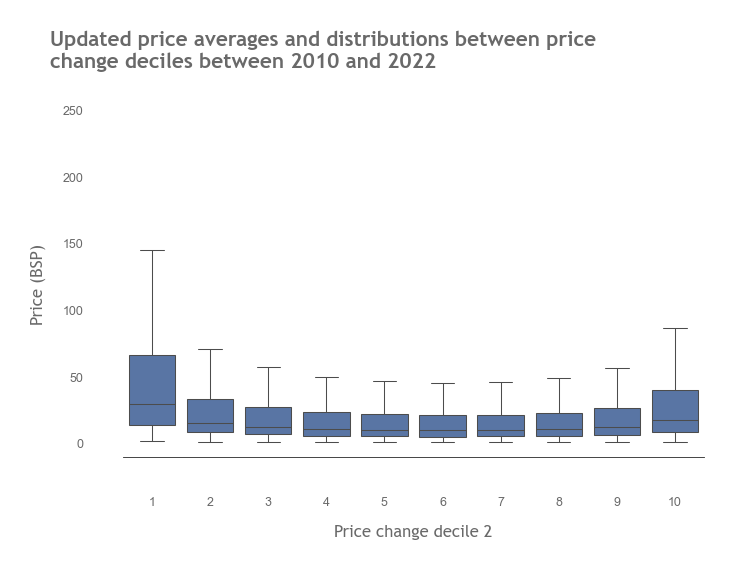

In [13]:
# create the figure and axes
fig, ax = plt.subplots()

# plot boxplot
sns.boxplot(x='change_morning_bsp_decile_2', y='bsp', data=df, showfliers=False, linewidth=.25, color='b', ax=ax)

# set title and axis labels
ax.set_title('Updated price averages and distributions between price\nchange deciles between 2010 and 2022',
             fontdict=title_font, x=-0.125, y=1.05, ha='left')
ax.set_ylabel('Price (BSP)', fontdict=label_font)
ax.set_xlabel('Price change decile 2', fontdict=label_font)

# adjust axis, grid lines
sns.despine(left=True)
ax.spines['bottom'].set_linewidth(.2)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)

# set range
plt.ylim(-10,250)

plt.show()

In [14]:
df['change_morning_bsp_decile_2'].corr(df['bsp']).round(3)

-0.116

In [15]:
df[df.change_morning_bsp_decile_2==1].bsp.mean().round(3)

54.877

As observed in the preceding plots, the first few deciles exhibit higher prices. This finding is not surprising, as the more a price drifts, the
more likely it is to end up higher. Let's delve deeper into the first 'Price Change Decile 2', which consists of the most significant drifters.
To gain a better understanding, we can divide this group into 10 different 'Drifters Deciles' based on the magnitude of theirprice
change, ranking from the largest to the smallest. This will help us isolate the cluster of the most significant drifters within the already
prominent 1 st price change decile.

`barplot` that shows the total profit/loss of our drifter percentiles from 2010-2022.

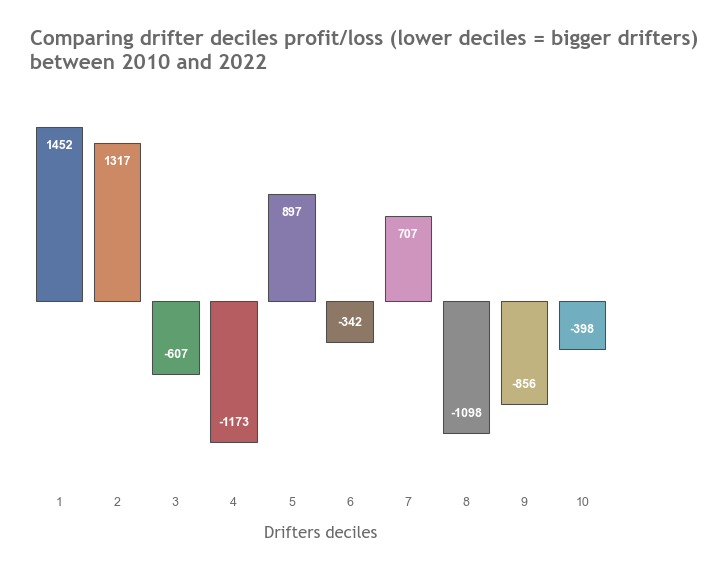

In [16]:
# data
drifters = df[df.change_morning_bsp_decile_2==1].copy()
drifters["drifters_deciles"] = pd.qcut(
    drifters["change_morning_bsp_compared_to_bsp_ave"], q=10, precision=1, labels=range(1, 11))

# create the figure and axes
fig, ax = plt.subplots()

# plot barplot
sns.barplot(x='drifters_deciles', y='bspr', data=drifters, estimator=sum , edgecolor='.3', linewidth=0.25, errwidth=.5, errorbar=None, ax=ax)

# set title and axis labels
ax.set_title('Comparing drifter deciles profit/loss (lower deciles = bigger drifters)\nbetween 2010 and 2022',
             fontdict=title_font, x=0, y=1.05, ha='left')
ax.set_ylabel('')
ax.set_xlabel('Drifters deciles', fontdict=label_font)

# adjust axis, grid lines
sns.despine(left=True, bottom=True)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)
plt.yticks([], [])

# add bar labels
bar_labels = ['{:.0f}'.format(rect.get_height())for rect in ax.containers[0]]
plt.bar_label(ax.containers[0], fontsize=3, color='white', weight='bold', padding=-6, labels=bar_labels)

plt.show()

`Displot` comparing the price of winning horses in each `drifters_percentile`

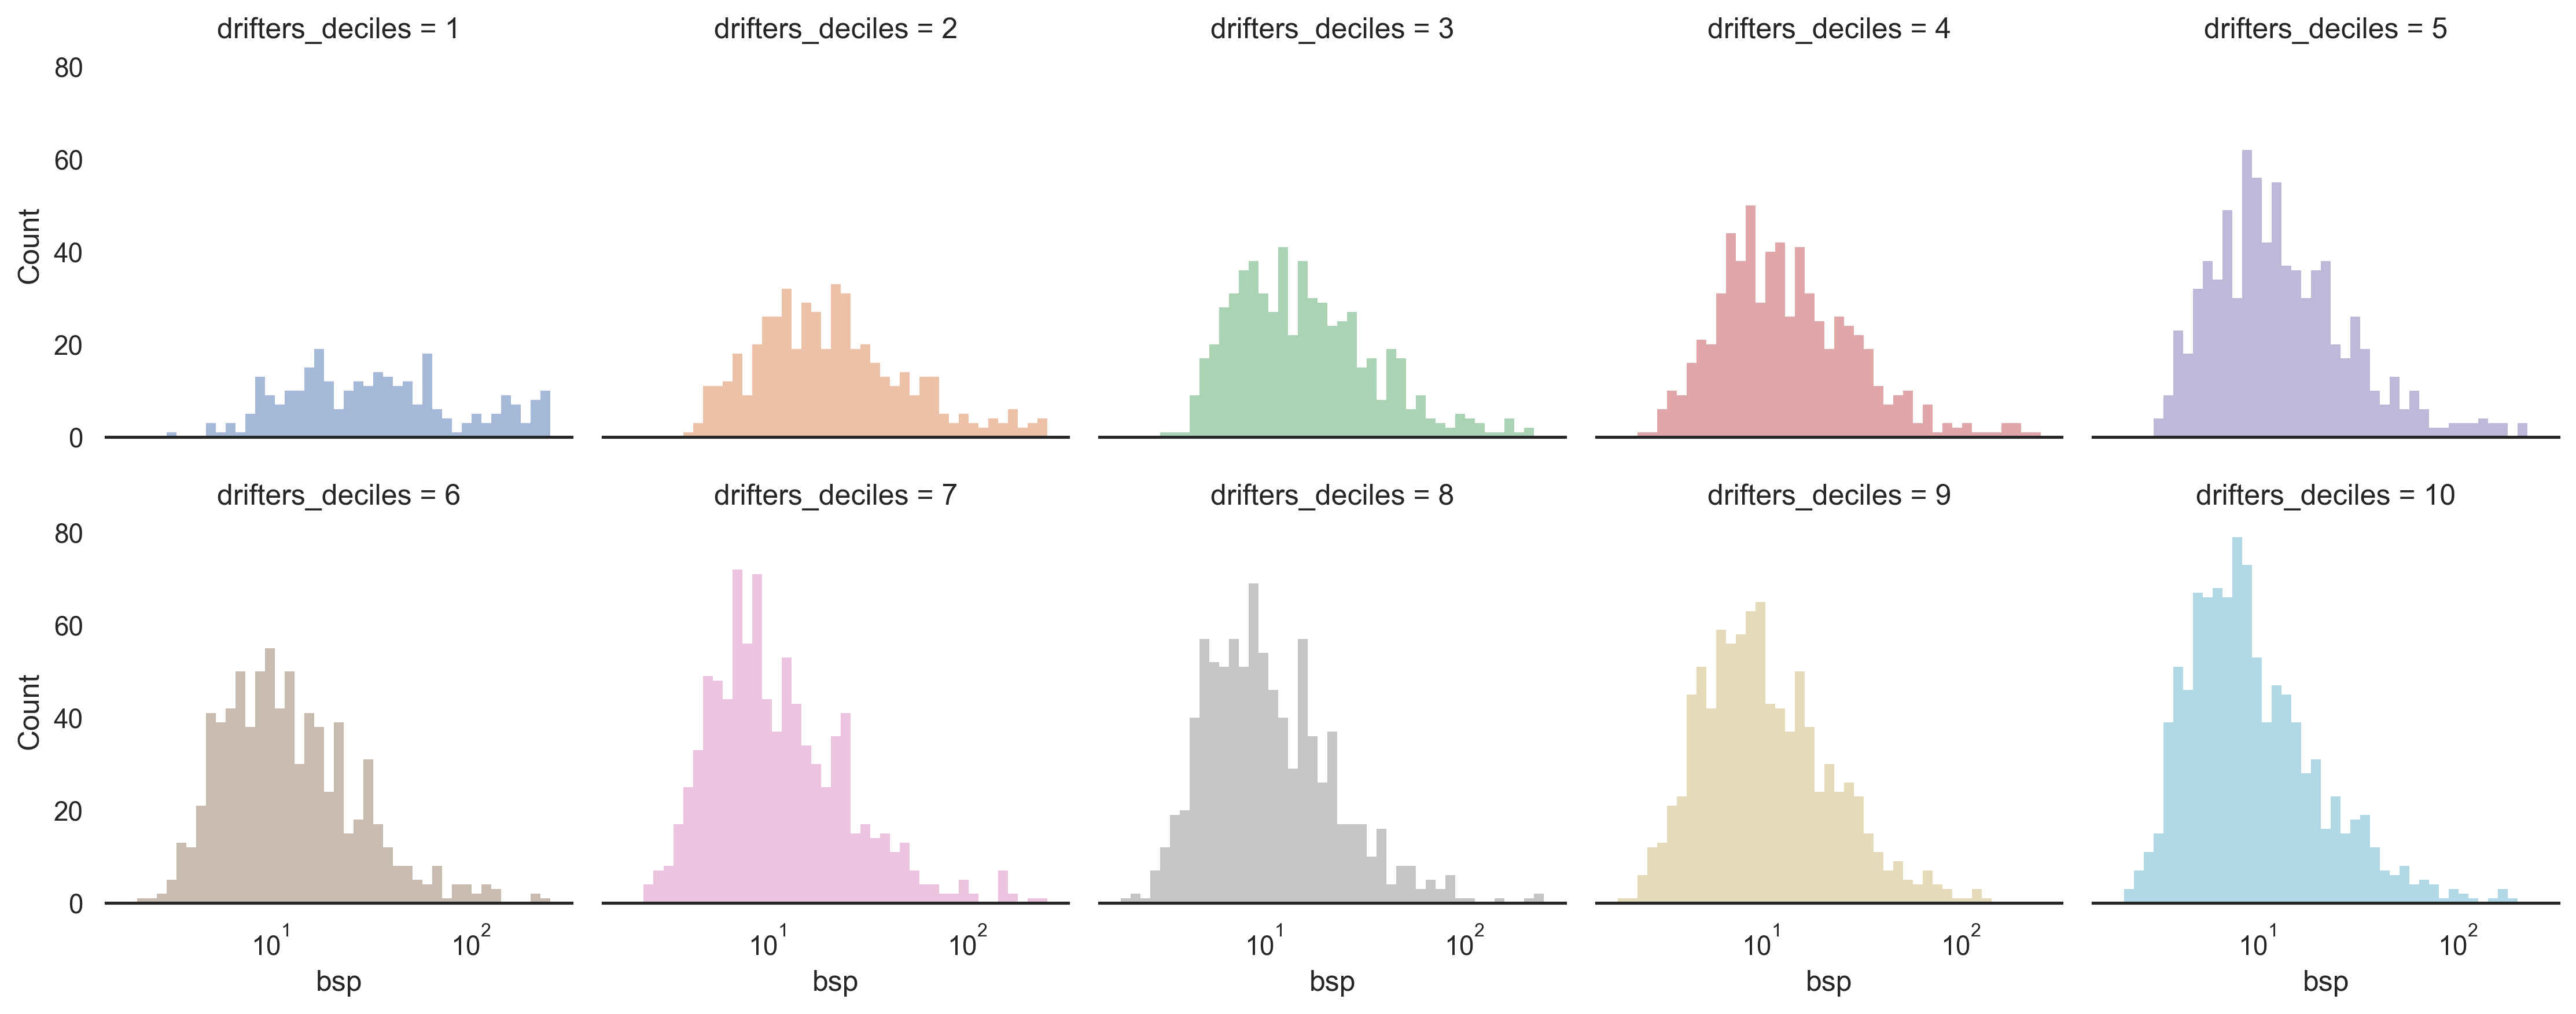

In [17]:
# data
drifters_winners = drifters[(drifters['W/L']==1) & (drifters.bspr>0)].copy()
drifters_winners["drifters_winners_percentiles"] = pd.qcut(
    drifters_winners["change_morning_bsp_compared_to_bsp_ave"], q=10, precision=1, labels=range(1, 11))

# plot displot
sns.displot(drifters_winners, x='bsp', col='drifters_deciles', edgecolor='.3',
                 hue='drifters_deciles', log_scale=(True, False), col_wrap=5, height=3, legend=False, linewidth=0)

# despine
sns.despine(left=True)

plt.show()

1st drifters_percentile

In [18]:
biggest_drifters = drifters[drifters.drifters_deciles==1].copy()
biggest_drifters[['bsp', 'change_morning_bsp_compared_to_bsp_ave', 'bspr']].describe()

,bsp,change_morning_bsp_compared_to_bsp_ave,bspr
count,14059.000000,14059.000000,14059.000000
mean,108.611665,0.284769,0.103281
std,72.599374,0.064836,11.418496
min,3.116302,0.007619,-1.000000
25%,43.298302,0.256055,-1.000000
50%,95.887569,0.303095,-1.000000
75%,170.000000,0.333294,-1.000000
max,250.000000,0.354958,244.020000


`scatterplot` showing the distribution of winning prices for all winners in `biggest_drifters`.

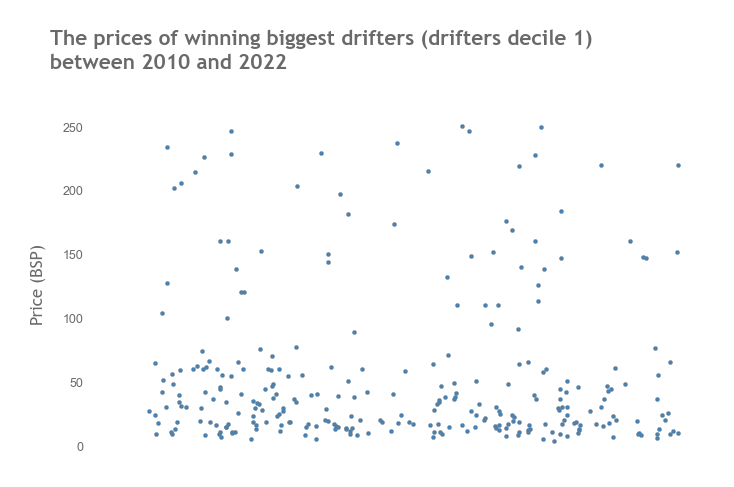

In [19]:
# data
biggest_drifters_winners = biggest_drifters.query('bspr>0')

# create the figure and axes
fig, ax = plt.subplots()

# plot scatterplot
sns.scatterplot(data=biggest_drifters_winners, x=biggest_drifters_winners.index, y='bsp', 
                label="Winners", color="steelblue", edgecolor='0.5', legend=False, s=1, ax=ax)

# set title and axis labels
ax.set_title('The prices of winning biggest drifters (drifters decile 1)\nbetween 2010 and 2022',
             fontdict=title_font, x=-0.125, y=1.05, ha='left')
ax.set_ylabel('Price (BSP)', fontdict=label_font)
ax.set_xlabel('')

# adjust axis, grid lines
sns.despine(left=True, bottom=True)

# adjust parameters
plt.xticks([], [])
ax.tick_params(colors='dimgrey', labelsize=3)

plt.show()

In [20]:
biggest_drifters_winners[['bspr']].describe()

,bspr
count,287.000000
mean,53.045382
std,59.476881
min,2.073976
25%,14.553089
50%,28.666879
75%,57.820000
max,244.020000


In [21]:
print(f'Total Number of Biggest Drifters = {len(biggest_drifters)}')
print(f'Total Number of Biggest Drifters Winners = {len(biggest_drifters_winners)}')
print(f'Total Number of Biggest Drifters Winners Under 200 = {len(biggest_drifters_winners[biggest_drifters_winners.bsp<200])}')
print(f'Total Number of Biggest Drifters Winners Over 200 = {len(biggest_drifters_winners[biggest_drifters_winners.bsp>200])}')
print(f'Profit/Loss = {(biggest_drifters.bspr.sum())}')
print(f'ROI = {((biggest_drifters.bspr.sum()/len(biggest_drifters)*100).round(2))}%')

Total Number of Biggest Drifters = 14059
Total Number of Biggest Drifters Winners = 287
Total Number of Biggest Drifters Winners Under 200 = 269
Total Number of Biggest Drifters Winners Over 200 = 18
Profit/Loss = 1452.02451336228
ROI = 10.33%


In [22]:
biggest_drifters[biggest_drifters.bsp>200].bspr.count()

2100

In [23]:
biggest_drifters[biggest_drifters.bsp>200].bspr.sum()

1891.224162208

In [24]:
biggest_drifters[biggest_drifters.bsp<200].bspr.count()

11820

In [25]:
biggest_drifters[biggest_drifters.bsp<200].bspr.sum()

-300.1996488457199